In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math


#import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.image as mpimg
from  matplotlib import pyplot
import cv2
import random
from PIL import Image
from sklearn.utils import class_weight
import numpy
import codecs
import xmltodict

import imgaug as ia
from imgaug import augmenters as iaa
import math



import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda,RepeatVector,Dot
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape,merge,Concatenate,Add,Dropout
import keras.backend as K
import math
from keras.activations import softmax,tanh
import tensorflow as tf
from keras.applications.vgg16 import VGG16


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D,Softmax
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            #self.model.save_weights(filepath, overwrite=True)
                            print("asd")
                            try:
                                with open(filepath,'wb') as f:
                                    pickle.dump(self.model.get_weights(),f)
                            except Exception as ex:
                                print("Could not write",ex)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

In [3]:
# !pip install keras
#num_labels = len(np.unique(labels))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2884512608732327931, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13840980736521713160
 physical_device_desc: "device: XLA_CPU device"]

In [5]:
def process_image_keypoints(img,bbox_coords):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    bbox_coordinates = []
    for a,b in bbox_coords:
        a = float(a)*ratio
        b = float(b)*ratio
        bbox_coordinates.append([a+left,b+top])
    return new_im,bbox_coordinates

In [6]:
def process_image_keypoints_nobox(img):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_im,[left,top,ratio]

In [7]:
count_correct = 0
count_wrong = 0
images = []
bboxes = []
image_sizes = []
image_names = []
for file in os.listdir("/tf/data/gender_annotations/"):
    try:
        with open('/tf/data/gender_annotations/'+file,'r') as f:
            text = f.read()
            d = xmltodict.parse(text)
        path = d['annotation']['path']
        rel_path = "/home/parmeet1992/Pictures/"
        
        path = path.split(rel_path)[1]
        path = "/tf/data/" + path
        bgr_img = cv2.imread(path)
        img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        
        obj = d['annotation']['object'][0] if isinstance(d['annotation']['object'],list) else d['annotation']['object']
        bbox = obj['bndbox']                
        bbox_coords = [(bbox['xmin'],bbox['ymin']),(bbox['xmax'],bbox['ymax'])]


        img,bbox_coords = process_image_keypoints(img,bbox_coords)
        bbs = ia.BoundingBoxesOnImage([
            ia.BoundingBox(x1=bbox_coords[0][0], y1=bbox_coords[0][1], x2=bbox_coords[1][0], y2=bbox_coords[1][1])
        ], shape=img.shape)

        images.append(img)
        bboxes.append(bbs)
        count_correct += 1
    except Exception as ex:
        print(ex)
        count_wrong += 1

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



KeyboardInterrupt: 

In [572]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        #iaa.Fliplr(0.5), # horizontally flip 50% of all images
        #iaa.Flipud(0.5), # vertically flip 50% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)}, # translate by -20 to +20 percent (per axis)
            rotate=(-2, 2), # rotate by -45 to +45 degrees
            #shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.ContrastNormalization((0.9, 1.10), per_channel=0.5), # improve or worsen the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [8]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        sometimes(iaa.Affine(
            #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                #iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.ContrastNormalization((0.9, 1.10), per_channel=0.5), # improve or worsen the contrast
            ],
            random_order=True
        )
    ],
    random_order=True
)

In [348]:
def augment_images(images,bboxes,times):
    all_bboxes = []
    
    
    images = [(x[:,:,:] * 255.0).astype(np.uint8) for x in images]
    all_images = list(images)
    
    for bbs in bboxes:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
    #print(len(all_images))
    #print(len(all_bboxes))
    
    for i in range(times):
        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images(images)
        bbs_aug = seq_det.augment_bounding_boxes(bboxes)
        for bbs in bbs_aug:
            all_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
        
        all_images = all_images + list(image_aug)
        #all_image_sizes = all_image_sizes + list(image_sizes)
    all_images = [(x[:,:,:] / 255.0).astype(np.float64) for x in all_images]
    return all_images,all_bboxes

In [9]:
X_normalized = [(x[:,:,:].astype(np.float64)) / 255.0 for x in images]
X_train, X_test, y_train, y_test = train_test_split(X_normalized,bboxes,test_size=0.20,random_state=42,shuffle=True)
test_bboxes = []
for bbs in list(y_test):
    test_bboxes.append(np.array([bbs.bounding_boxes[0].x1,bbs.bounding_boxes[0].y1,bbs.bounding_boxes[0].x2,bbs.bounding_boxes[0].y2]))
train_images,train_bboxes = augment_images(X_train,y_train,2)

NameError: name 'augment_images' is not defined

In [7]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
x = Reshape((4,),name='localization_output')(x)


model = Model(inputs=cnn_base.input, outputs=x)
sgd = keras.optimizers.SGD(lr=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="mean_squared_error", optimizer=sgd, metrics=['accuracy',iou_metric])
initial_weights = model.get_weights()

W0410 14:20:44.810614 140623919392512 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [172]:
try:
    with open('vgg16-gender-box-weights8.hd5','rb') as f:
        model_weights = pickle.load(f)
        model.set_weights(model_weights)
        print("loaded weights")
except:
    print("not present")
checkpoint = CustomModelCheckpoint('vgg16-gender-box-weights8.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
callbacks_list = [checkpoint]
history = model.fit(np.array(train_images),np.array(train_bboxes),validation_data=(np.array(X_test),np.array(test_bboxes)),epochs=30,batch_size=5,callbacks=callbacks_list)

loaded weights
Train on 702 samples, validate on 59 samples
Epoch 1/30
702/702 [==============================] - 14s 20ms/step - loss: 111.3744 - acc: 0.9430 - iou_metric: 0.6559 - val_loss: 37.0380 - val_acc: 1.0000 - val_iou_metric: 0.7770

Epoch 00001: val_loss improved from inf to 37.03798, saving model to vgg16-gender-box-weights8.hd5
asd
Epoch 2/30
702/702 [==============================] - 10s 15ms/step - loss: 110.7253 - acc: 0.9473 - iou_metric: 0.6588 - val_loss: 36.0007 - val_acc: 1.0000 - val_iou_metric: 0.7804

Epoch 00002: val_loss improved from 37.03798 to 36.00070, saving model to vgg16-gender-box-weights8.hd5
asd
Epoch 3/30
702/702 [==============================] - 10s 15ms/step - loss: 113.5561 - acc: 0.9345 - iou_metric: 0.6529 - val_loss: 35.6070 - val_acc: 1.0000 - val_iou_metric: 0.7798

Epoch 00003: val_loss improved from 36.00070 to 35.60697, saving model to vgg16-gender-box-weights8.hd5
asd
Epoch 4/30
702/702 [==============================] - 10s 15ms/step -

KeyboardInterrupt: 

In [9]:
with open('vgg16-gender-box-weights8.hd5','rb') as f:
    model_weights = pickle.load(f)
    model.set_weights(model_weights)
    print("loaded weights")

loaded weights


In [10]:
df = pd.read_csv('/tf/data/labels.csv')
df2 = pd.read_csv('/tf/data/gender.csv')

labels_dict = {}

for idx,row in df.iterrows():
    labels_dict['tangiervisit2'+str(row['id'])] = row['gender']
for idx,row in df2.iterrows():
    labels_dict['tangiervisit1'+str(row['id'])] = row['gender']

In [11]:
count_correct = 0
count_wrong = 0
images = []
labels = []
image_sizes = []
image_names = []

# folders = ['/tf/data/gender_images/tangier_visit2_dslr','/tf/data/gender_images/tangier-visit2-gender']
# for folder in folders:
#     for file in os.listdir(folder):
#         try:
#             bgr_img = cv2.imread(folder+"/"+file)
            
#             img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
#             img_temp,corr = process_image_keypoints_nobox(img)
#             img_temp = (img_temp[:,:,:] / 255.0).astype(np.float64)
#             label = file.split(".")[0].split("_")[0]
            
#             [[xmin,ymin,xmax,ymax]] = model.predict(np.expand_dims(img_temp,0))
#             [left,top,ratio] = corr
#             xmin,xmax = (xmin - left)/ratio,(xmax - left)/ratio
#             ymin,ymax = (ymin - top)/ratio,(ymax - top)/ratio            
            
#             img = img[int(ymin):int(ymax),int(xmin):int(xmax),:]
#             image_temp,_= process_image_keypoints_nobox(img)
#             if 'tangiervisit2'+label in labels_dict:
#                 images.append(image_temp)
#                 labels.append(labels_dict['tangiervisit2'+label])
#             count_correct += 1
#         except Exception as ex:
#             print(ex)
#             count_wrong += 1
folders = ['/tf/data/tangier_lobster/']
for folder in folders:
    for file in os.listdir(folder):
        try:
            bgr_img = cv2.imread(folder+"/"+file)
            
            img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
            img_temp,corr = process_image_keypoints_nobox(img)
            img_temp = (img_temp[:,:,:] / 255.0).astype(np.float64)
            label = file.split(".")[0].split("_")[0]
            
            [[xmin,ymin,xmax,ymax]] = model.predict(np.expand_dims(img_temp,0))
            [left,top,ratio] = corr
            xmin,xmax = (xmin - left)/ratio,(xmax - left)/ratio
            ymin,ymax = (ymin - top)/ratio,(ymax - top)/ratio            
            
            img = img[int(ymin):int(ymax),int(xmin):int(xmax),:]
            image_temp,_= process_image_keypoints_nobox(img)
            if 'tangiervisit1'+label in labels_dict:
                images.append(image_temp)
                labels.append(labels_dict['tangiervisit1'+label])
            count_correct += 1
        except Exception as ex:
            print(ex)
            count_wrong += 1

OpenCV(4.0.0) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [15]:
sum([i=='M' for i in labels])

120

M


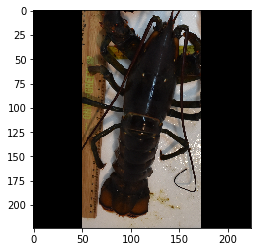

In [16]:
idx = idx + 1
plt.imshow(images[-1 - idx])
print(labels[-1 - idx])
#plt.imshow(images[idx])

In [621]:
def augment_images(images,labels,times):
    
    images = [(x[:,:,:] * 255.0).astype(np.uint8) for x in images]
    
    all_images = list(images)
    all_labels = list(labels)
    
    
    
    for i in range(times):
        seq_det = seq.to_deterministic()
        image_aug = seq_det.augment_images(images)
        all_images = all_images + list(image_aug)
        all_labels = all_labels + list(labels)        
    all_images = [(x[:,:,:] / 255.0).astype(np.float64) for x in all_images]
    return all_images,all_labels

In [623]:
images_temp = [(x[:,:,:] / 255.0).astype(np.float64) for x in images]

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=100)
test_cvscores = []
validation_cvscores = []
fusion_model_info = []
kfold_data = []

i = 0
for train, test in kf.split(images_temp,labels):
    i = i + 1
    print(i)
    train_images,train_labels = augment_images(np.array(images_temp)[train],np.array(labels)[train],2)
    kfold_data.append([train_images,train_labels,np.array(images_temp)[test],np.array(labels)[test]])

1
2
3
4
5


In [624]:
with open('data-gender2240.pckl','wb') as file:
    pickle.dump(kfold_data[0],file)
with open('data-gender2241.pckl','wb') as file:
    pickle.dump(kfold_data[1],file)
with open('data-gender2242.pckl','wb') as file:
    pickle.dump(kfold_data[2],file)
with open('data-gender2243.pckl','wb') as file:
    pickle.dump(kfold_data[3],file)
with open('data-gender2244.pckl','wb') as file:
    pickle.dump(kfold_data[4],file)

In [7]:
def attention_block(x,K,labels,w,h):
    H = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    H = BatchNormalization()(H)
    spatial_softmax = Lambda(lambda x:softmax(H,axis=3))(H)
    O = Conv2D(labels*K, kernel_size=(w, h), padding="same")(x)
    O = BatchNormalization()(O)
    rH = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=3))(spatial_softmax)
    o = Lambda(lambda x: tf.einsum('bijk,bijk->bk',x[0],x[1]))([O,rH])
    tempH = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    tempH = BatchNormalization()(tempH)
    gh = Lambda(lambda x: softmax(tanh(tf.einsum('bijk,bijk->bk',x[0],x[1])),axis=1))([tempH,spatial_softmax])
    rgh = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=1))(gh)
    of = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([rgh,o])
    new_shape = Reshape((labels,K))(of)
    out = Lambda(lambda x: keras.backend.sum(x,axis=2))(new_shape)
    out = Dense(labels,activation='sigmoid')(out)
    #x = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    #inter = Lambda(lambda x: Flatten()(keras.backend.mean(x,axis=3)))(x)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(x)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(inter)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    print(inter.shape)
    inter = Conv2D(1, kernel_size=(w, h), padding="same")(inter)
    inter = Flatten()(inter)
    weight = Dense(labels,activation='tanh')(inter)
    return out,weight

In [13]:
K = 5
labels = 1
w,h = 3,3

cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False


x = cnn_base.get_layer('block3_conv3').output
final1,weight1 = attention_block(x,K,labels,w,h)
#final1 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final1,weight1])

x = cnn_base.get_layer('block4_conv3').output
final2,weight2 = attention_block(x,K,labels,w,h)

#final2 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final2,weight2])

x = cnn_base.get_layer('block5_pool').output
inter = Lambda(lambda x: Flatten()(x[:,:,:,0]))(x)
weight3 = Dense(1,activation='tanh')(inter)

x = Flatten()(x)
x = Dense(64,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(1,activation='sigmoid')(x)

weight_concat = Concatenate()([weight1,weight2,weight3])
weight_concat = Reshape((labels,3))(weight_concat)
weight_concat = Softmax(axis=2)(weight_concat)

final = Concatenate()([final1,final2,x])
final = Reshape((labels,3))(final)


sum_final = Lambda(lambda x: tf.einsum('bij,bij->bij',x[0],x[1]))([weight_concat,final])
sum_final = Lambda(lambda x: keras.backend.sum(x,axis=2))(sum_final)
sum_final = Dense(labels,activation='sigmoid')(sum_final)

model = Model(inputs=cnn_base.input, outputs=sum_final)

#sgd = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(lr=0.001)
#model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=['accuracy'])
model.compile(loss="binary_crossentropy",optimizer=adam, metrics=['accuracy'])
print(model.summary())
initial_weights = model.get_weights()

(?, 14, 14, 128)
(?, 7, 7, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____________________________________________________________________________

In [31]:
test_scores = []
train_scores = []

test_pred = []
train_pred = []

history_record = []

In [37]:
for i in range(5):
    eps = 350
    print("Loading file")
    with open('data-gender224'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    try:
        with open('vgg16-gender-classification_batch_tanhadam001'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    print("loaded")
    train_ls = []
    for lb in train_labels:
        if lb=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for lb in test_labels:
        if lb=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)
    class_weights = class_weight.compute_class_weight('balanced',np.unique(train_ls),train_ls)
    checkpoint = CustomModelCheckpoint('vgg16-genderclassification_batch_tanhadam001'+str(i)+'.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
    from keras.callbacks import EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=250, verbose=0, mode='min', baseline=None, restore_best_weights=False)

    callbacks_list = [checkpoint,earlyStopping]
    history = model.fit(x=np.array(train_images),y=np.array(train_ls),batch_size=5,epochs=eps,
                           validation_data=(np.array(test_images),np.array(test_ls)),callbacks=callbacks_list,class_weight=class_weights)
#     history_record.append(history)
#     train_score = model.evaluate(x=np.array(train_images),y=np.array(train_ls),batch_size=5)
#     test_score = model.evaluate(x=np.array(test_images),y=np.array(test_ls),batch_size=5)
#     train_scores.append(train_score)
#     test_scores.append(test_score)
    
#     print("predicting")
#     print("Test Score",test_score)
#     train_predictions = model.predict(x=np.array(train_images),batch_size=50)
#     test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
#     train_pred.append(train_predictions)
#     test_pred.append(test_predictions)

Loading file
setting initial weights
loaded
Train on 381 samples, validate on 32 samples
Epoch 1/350
381/381 [==============================] - 8s 22ms/step - loss: 0.6727 - acc: 0.7559 - val_loss: 0.6530 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 0.65297, saving model to vgg16-genderclassification_batch_tanhadam0010.hd5
asd
Epoch 2/350
381/381 [==============================] - 8s 22ms/step - loss: 0.6360 - acc: 0.7559 - val_loss: 0.6251 - val_acc: 0.7500

Epoch 00002: val_loss improved from 0.65297 to 0.62510, saving model to vgg16-genderclassification_batch_tanhadam0010.hd5
asd
Epoch 3/350
381/381 [==============================] - 9s 22ms/step - loss: 0.6103 - acc: 0.7559 - val_loss: 0.6055 - val_acc: 0.7500

Epoch 00003: val_loss improved from 0.62510 to 0.60547, saving model to vgg16-genderclassification_batch_tanhadam0010.hd5
asd
Epoch 4/350
381/381 [==============================] - 9s 22ms/step - loss: 0.5936 - acc: 0.7559 - val_loss: 0.5921 - val_acc: 0.750


Epoch 00033: val_loss improved from 0.55992 to 0.55971, saving model to vgg16-genderclassification_batch_tanhadam0010.hd5
asd
Epoch 34/350
381/381 [==============================] - 9s 23ms/step - loss: 0.5520 - acc: 0.7559 - val_loss: 0.5593 - val_acc: 0.7500

Epoch 00034: val_loss improved from 0.55971 to 0.55934, saving model to vgg16-genderclassification_batch_tanhadam0010.hd5
asd
Epoch 35/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5517 - acc: 0.7559 - val_loss: 0.5595 - val_acc: 0.7500

Epoch 00035: val_loss did not improve from 0.55934
Epoch 36/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5515 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00036: val_loss improved from 0.55934 to 0.55893, saving model to vgg16-genderclassification_batch_tanhadam0010.hd5
asd
Epoch 37/350
381/381 [==============================] - 9s 23ms/step - loss: 0.5514 - acc: 0.7559 - val_loss: 0.5590 - val_acc: 0.7500

Epoch 00037: val_loss did 

381/381 [==============================] - 9s 24ms/step - loss: 0.5504 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00119: val_loss did not improve from 0.55892
Epoch 120/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5503 - acc: 0.7559 - val_loss: 0.5590 - val_acc: 0.7500

Epoch 00120: val_loss did not improve from 0.55892
Epoch 121/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5504 - acc: 0.7559 - val_loss: 0.5590 - val_acc: 0.7500

Epoch 00121: val_loss did not improve from 0.55892
Epoch 122/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5505 - acc: 0.7559 - val_loss: 0.5591 - val_acc: 0.7500

Epoch 00122: val_loss did not improve from 0.55892
Epoch 123/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5504 - acc: 0.7559 - val_loss: 0.5590 - val_acc: 0.7500

Epoch 00123: val_loss did not improve from 0.55892
Epoch 124/350
381/381 [==============================] - 9s 24ms/step - lo


Epoch 00162: val_loss did not improve from 0.55892
Epoch 163/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5499 - acc: 0.7559 - val_loss: 0.5590 - val_acc: 0.7500

Epoch 00163: val_loss did not improve from 0.55892
Epoch 164/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5498 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00164: val_loss did not improve from 0.55892
Epoch 165/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5499 - acc: 0.7559 - val_loss: 0.5590 - val_acc: 0.7500

Epoch 00165: val_loss did not improve from 0.55892
Epoch 166/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5498 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00166: val_loss did not improve from 0.55892
Epoch 167/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5499 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00167: val_loss improved from 0.55892 to 0.55891, sav


Epoch 00203: val_loss did not improve from 0.55876
Epoch 204/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5495 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00204: val_loss did not improve from 0.55876
Epoch 205/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5494 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00205: val_loss did not improve from 0.55876
Epoch 206/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5493 - acc: 0.7559 - val_loss: 0.5588 - val_acc: 0.7500

Epoch 00206: val_loss did not improve from 0.55876
Epoch 207/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5493 - acc: 0.7559 - val_loss: 0.5588 - val_acc: 0.7500

Epoch 00207: val_loss did not improve from 0.55876
Epoch 208/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5495 - acc: 0.7559 - val_loss: 0.5589 - val_acc: 0.7500

Epoch 00208: val_loss did not improve from 0.55876
Epoch 20

381/381 [==============================] - 9s 24ms/step - loss: 0.5490 - acc: 0.7559 - val_loss: 0.5587 - val_acc: 0.7500

Epoch 00245: val_loss did not improve from 0.55867
Epoch 246/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5489 - acc: 0.7559 - val_loss: 0.5587 - val_acc: 0.7500

Epoch 00246: val_loss did not improve from 0.55867
Epoch 247/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5489 - acc: 0.7559 - val_loss: 0.5587 - val_acc: 0.7500

Epoch 00247: val_loss improved from 0.55867 to 0.55867, saving model to vgg16-genderclassification_batch_tanhadam0010.hd5
asd
Epoch 248/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5489 - acc: 0.7559 - val_loss: 0.5587 - val_acc: 0.7500

Epoch 00248: val_loss did not improve from 0.55867
Epoch 249/350
381/381 [==============================] - 9s 24ms/step - loss: 0.5489 - acc: 0.7559 - val_loss: 0.5587 - val_acc: 0.7500

Epoch 00249: val_loss did not improve from 0.55867

KeyboardInterrupt: 

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,accuracy_score
test_accuracy = []
train_accuracy = []

test_f1 = []
train_f1 = []

for i in range(3):
    with open('data-gender224'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    with open('vgg16-gender-classification_batch_tanh_adam0001'+str(i)+'.hd5','rb') as f:
        model_weights = pickle.load(f)
        print("loaded model")
    model.set_weights(model_weights)
    train_ls = []
    for lb in train_labels:
        if lb=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for lb in test_labels:
        if lb=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)


    test_predictions = model.predict(np.array(test_images))
    #test_predictions = test_pred[i]
    test_f1.append(f1_score(test_ls,test_predictions>0.5,average='macro'))
    test_accuracy.append(accuracy_score(test_ls,test_predictions>0.5))
print("Training accuracy mean",np.mean(train_accuracy))
print("Training accuracy var",np.std(train_accuracy))

print("Testing accuracy mean",np.mean(test_accuracy))
print("Testing accuracy var",np.std(test_accuracy))

print("Training f1 mean",np.mean(train_f1))
print("Training f1 var",np.var(train_f1))

print("Testing f1 mean",np.mean(test_f1))
print("Testing f1 var",np.var(test_f1))
#     train_predictions = model.predict(np.array(train_images))
#     #train_predictions = train_pred[i]
#     train_f1.append(f1_score(train_ls,train_predictions>0.5,average='macro'))
#     train_accuracy.append(accuracy_score(train_ls,train_predictions>0.5))

loaded model
loaded model
loaded model
Training accuracy mean nan
Training accuracy var nan
Testing accuracy mean 0.8645833333333334
Testing accuracy var 0.01473139127471974
Training f1 mean nan
Training f1 var nan
Testing f1 mean 0.7976528047116282
Testing f1 var 0.000759724287544102


In [33]:
labs = []
for i in (test_predictions>0.5):
    labs.append(i[0])
idx = 0
for a,b in zip(labs,test_ls):
    idx = idx + 1
    if a!=b:
        print(idx)

2
3
8
19
20


M


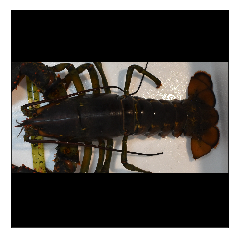

In [43]:
idx = 20
plt.imshow(test_images[idx])
plt.xticks([])
plt.yticks([])
plt.savefig("gender_incorrect_male2.jpg")
print(test_labels[idx])

In [ ]:
plt.plot(history_record[0].history['acc'],color='b',label='training accuracy')
plt.plot(history_record[0].history['val_acc'],color='r',label='testing accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation Loss curves')
plt.legend()
plt.savefig('gender-accuracy-attention.jpg')
plt.show()

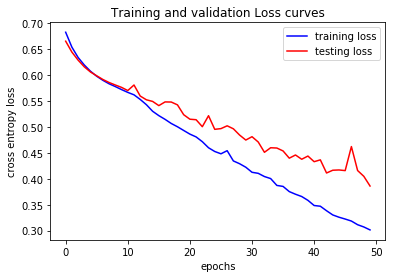

In [662]:
plt.plot(history_record[3].history['loss'],color='b',label='training loss')
plt.plot(history_record[3].history['val_loss'],color='r',label='testing loss')
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.title('Training and validation Loss curves')
plt.legend()
plt.savefig('gender-loss-attention.jpg')
plt.show()

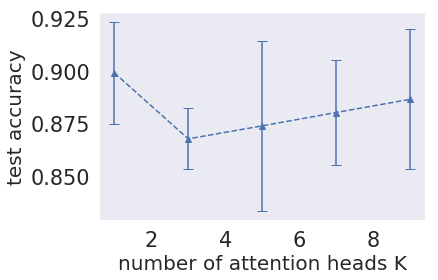

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
means = [0.8991,0.867741,0.8739,0.88024,0.88649]
variances = [0.0242,0.01451,0.0403679,0.025030,0.033285]
plt.errorbar([1,3,5,7,9],means,variances,label='Test accuracy',linestyle='--', marker='^',capsize=5)
plt.xlabel("number of attention heads K",fontsize=20)
plt.ylabel("test accuracy",fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig('gender-choose-attention-headk.jpg')
plt.show()

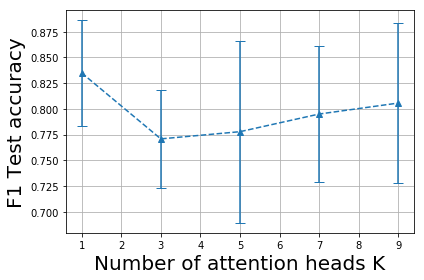

In [10]:
means = [0.8350,0.77090,0.7779,0.79504,0.805714]
variances = [0.0514,0.0479277,0.08843,0.0657,0.07789]
plt.errorbar([1,3,5,7,9],means,variances,label='Test accuracy',linestyle='--', marker='^',capsize=5)
plt.xlabel("Number of attention heads K",fontsize=20)
plt.ylabel("F1 Test accuracy",fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig('gender-choose-attention-headk-f1.jpg')
plt.show()

In [17]:
with open('data-gender2240.pckl','rb') as file:
    train_images,train_labels,test_images,test_labels = pickle.load(file)

In [17]:
K = 10
labels = 1
w,h = 3,3

cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    #if layer.name=='block5_conv3':
        #break
    layer.trainable = False


x = cnn_base.get_layer('block5_pool').output

x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(inputs=cnn_base.input, outputs=x)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model.summary())
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
print(len(train_labels))
print(len(test_labels))
381/3

381
32


127.0

loaded model


Training accuracy mean 1.0
Training accuracy var 0.0
Testing accuracy mean 0.90625
Testing accuracy var 0.0
Training f1 mean 1.0
Training f1 var 0.0
Testing f1 mean 0.8552036199095023
Testing f1 var 0.0


In [667]:
print("Training accuracy mean",train_accuracy)
print("Training accuracy var",train_accuracy)

print("Testing accuracy mean",test_accuracy)
print("Testing accuracy var",test_accuracy)

print("Training f1 mean",train_f1)
print("Training f1 var",train_f1)

print("Testing f1 mean",test_f1)
print("Testing f1 var",test_f1)

Training accuracy mean [1.0, 0.7559055118110236, 1.0, 1.0, 0.9895833333333334]
Training accuracy var [1.0, 0.7559055118110236, 1.0, 1.0, 0.9895833333333334]
Testing accuracy mean [0.90625, 0.75, 0.84375, 0.90625, 0.8387096774193549]
Testing accuracy var [0.90625, 0.75, 0.84375, 0.90625, 0.8387096774193549]
Training f1 mean [1.0, 0.4304932735426009, 1.0, 1.0, 0.9859134262655906]
Training f1 var [1.0, 0.4304932735426009, 1.0, 1.0, 0.9859134262655906]
Testing f1 mean [0.8552036199095023, 0.42857142857142855, 0.782312925170068, 0.8552036199095023, 0.6750524109014675]
Testing f1 var [0.8552036199095023, 0.42857142857142855, 0.782312925170068, 0.8552036199095023, 0.6750524109014675]


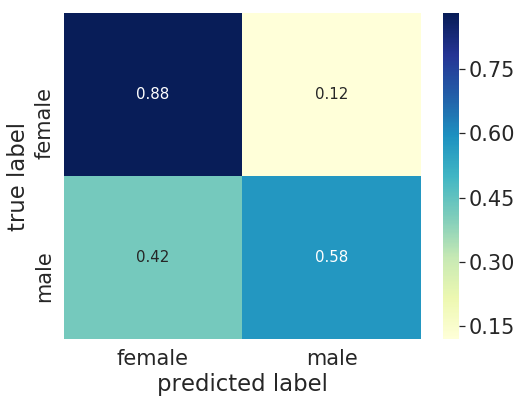

In [13]:
from sklearn.metrics import confusion_matrix

C_sum = np.zeros(2)

for i in range(1):    
    with open('data-gender224'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    with open('vgg16-gender-classification_att44'+str(i)+'.hd5','rb') as f:
        model_weights = pickle.load(f)
        print("loaded model")
    train_ls = []
    for lb in train_labels:
        if lb=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for lb in test_labels:
        if lb=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)
    model.set_weights(model_weights)
    test_predictions = model.predict(np.array(test_images))

    C = confusion_matrix(np.array(test_ls), (test_predictions>0.5).astype(int))
    C_sum = C_sum + C / C.astype(np.float).sum(axis=1).reshape(2,1)
confusion_matrix = C_sum/1

cm_df = pd.DataFrame(confusion_matrix,
                     index = ['Female','Male'], 
                     columns = ['Female','Male'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu",annot_kws={"size": 15})
#plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('gender-confusion-matrix.jpg')
plt.show()

In [16]:
np.mean([0.75,0.75,0.75,0.7742,0.75])
#np.std([0.75,0.75,0.75,0.7742,0.75])

0.75484

In [21]:
K = 10
labels = 1
w,h = 3,3

cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    #if layer.name=='block5_conv3':
        #break
    layer.trainable = False


x = cnn_base.get_layer('block5_pool').output

x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(inputs=cnn_base.input, outputs=x)

#sgd = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(0.001)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])
print(model.summary())
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:
test_scores = []
train_scores = []

test_pred = []
train_pred = []

history_record = []


for i in range(5):
    print("Loading file")
    with open('data-gender224'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    try:
        with open('vgg16-gender-classification_simple6_dp22_relu'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    print("loaded")
    train_ls = []
    for lb in train_labels:
        if lb=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for lb in test_labels:
        if lb=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)
    class_weights = class_weight.compute_class_weight('balanced',np.unique(train_ls),train_ls)
    checkpoint = CustomModelCheckpoint('vgg16-gender-classification_simple6_dp22_relu'+str(i)+'.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
    from keras.callbacks import EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='min', baseline=None, restore_best_weights=False)

    callbacks_list = [checkpoint,earlyStopping]
    history = model.fit(x=np.array(train_images),y=np.array(train_ls),batch_size=5,epochs=50,
                           validation_data=(np.array(test_images),np.array(test_ls)),callbacks=callbacks_list,class_weight=class_weights)
#     history_record.append(history)
#     train_score = model.evaluate(x=np.array(train_images),y=np.array(train_ls),batch_size=5)
#     test_score = model.evaluate(x=np.array(test_images),y=np.array(test_ls),batch_size=5)
#     train_scores.append(train_score)
#     test_scores.append(test_score)
    
#     print("predicting")
#     print("Test Score",test_score)
#     train_predictions = model.predict(x=np.array(train_images),batch_size=50)
#     test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
#     train_pred.append(train_predictions)
#     test_pred.append(test_predictions)

Loading file
setting initial weights
loaded
Train on 381 samples, validate on 32 samples
Epoch 1/50
381/381 [==============================] - 6s 15ms/step - loss: 0.7641 - acc: 0.6667 - val_loss: 0.5766 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 0.57664, saving model to vgg16-gender-classification_simple6_dp22_relu0.hd5
asd
Epoch 2/50
381/381 [==============================] - 5s 14ms/step - loss: 0.4546 - acc: 0.7559 - val_loss: 0.4429 - val_acc: 0.7500

Epoch 00002: val_loss improved from 0.57664 to 0.44290, saving model to vgg16-gender-classification_simple6_dp22_relu0.hd5
asd
Epoch 3/50
381/381 [==============================] - 5s 14ms/step - loss: 0.2799 - acc: 0.8373 - val_loss: 0.3888 - val_acc: 0.8438

Epoch 00003: val_loss improved from 0.44290 to 0.38884, saving model to vgg16-gender-classification_simple6_dp22_relu0.hd5
asd
Epoch 4/50
381/381 [==============================] - 5s 14ms/step - loss: 0.2682 - acc: 0.8373 - val_loss: 0.4198 - val_acc: 0.7500

KeyboardInterrupt: 

loaded model
loaded model
loaded model
loaded model
loaded model


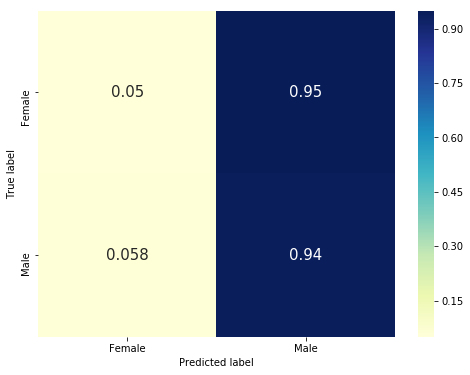

In [10]:
from sklearn.metrics import confusion_matrix

C_sum = np.zeros(2)

for i in range(5):    
    with open('data-gender224'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    with open('vgg16-gender-classification_simple6_dp4_relu'+str(i)+'.hd5','rb') as f:
        model_weights = pickle.load(f)
        print("loaded model")
    train_ls = []
    for lb in train_labels:
        if lb=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for lb in test_labels:
        if lb=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)
    model.set_weights(model_weights)
    test_predictions = model.predict(np.array(test_images))

    C = confusion_matrix(np.array(test_ls), (test_predictions>0.5).astype(int))
    C_sum = C_sum + C / C.astype(np.float).sum(axis=1).reshape(2,1)
confusion_matrix = C_sum/5

cm_df = pd.DataFrame(confusion_matrix,
                     index = ['Female','Male'], 
                     columns = ['Female','Male'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu",annot_kws={"size": 15})
#plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('gender-confusion-matrix-simple.jpg')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,accuracy_score
test_accuracy = []
train_accuracy = []

test_f1 = []
train_f1 = []

for i in range(5):
    with open('data-gender224'+str(i)+'.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    with open('vgg16-gender-classification_simple6_dp4_relu'+str(i)+'.hd5','rb') as f:
        model_weights = pickle.load(f)
        print("loaded model")
    model.set_weights(model_weights)
    train_ls = []
    for lb in train_labels:
        if lb=='M':
            train_ls.append(1)
        else:
            train_ls.append(0)
    test_ls = []
    for lb in test_labels:
        if lb=='M':
            test_ls.append(1)
        else:
            test_ls.append(0)


    test_predictions = model.predict(np.array(test_images))
    #test_predictions = test_pred[i]
    test_f1.append(f1_score(test_ls,test_predictions>0.5,average='macro'))
    test_accuracy.append(accuracy_score(test_ls,test_predictions>0.5))

    #train_predictions = model.predict(np.array(train_images))
#     train_predictions = train_pred[i]
#     train_f1.append(f1_score(train_ls,train_predictions>0.5,average='macro'))
#     train_accuracy.append(accuracy_score(train_ls,train_predictions>0.5))

loaded model
loaded model
loaded model
loaded model
loaded model


In [20]:
print("Training accuracy mean",np.mean(train_accuracy))
print("Training accuracy var",np.var(train_accuracy))

print("Testing accuracy mean",np.mean(test_accuracy))
print("Testing accuracy var",np.std(test_accuracy))

print("Training f1 mean",np.mean(train_f1))
print("Training f1 var",np.var(train_f1))

print("Testing f1 mean",np.mean(test_f1))
print("Testing f1 var",np.var(test_f1))

Training accuracy mean nan
Training accuracy var nan
Testing accuracy mean 0.7235887096774194
Testing accuracy var 0.06559208641450671
Training f1 mean nan
Training f1 var nan
Testing f1 mean 0.44028542171220514
Testing f1 var 0.00039060220486056816


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [691]:
print("Training accuracy mean",train_accuracy)
print("Training accuracy var",train_accuracy)

print("Testing accuracy mean",test_accuracy)
print("Testing accuracy var",test_accuracy)

print("Training f1 mean",train_f1)
print("Training f1 var",train_f1)

print("Testing f1 mean",test_f1)
print("Testing f1 var",test_f1)

Training accuracy mean [1.0, 1.0, 0.9973753280839895, 0.7559055118110236, 1.0]
Training accuracy var [1.0, 1.0, 0.9973753280839895, 0.7559055118110236, 1.0]
Testing accuracy mean [0.90625, 0.78125, 0.90625, 0.75, 0.8387096774193549]
Testing accuracy var [0.90625, 0.78125, 0.90625, 0.75, 0.8387096774193549]
Training f1 mean [1.0, 1.0, 0.9964307461707809, 0.4304932735426009, 1.0]
Training f1 var [1.0, 1.0, 0.9964307461707809, 0.4304932735426009, 1.0]
Testing f1 mean [0.8552036199095023, 0.7380116959064327, 0.8552036199095023, 0.42857142857142855, 0.6750524109014675]
Testing f1 var [0.8552036199095023, 0.7380116959064327, 0.8552036199095023, 0.42857142857142855, 0.6750524109014675]


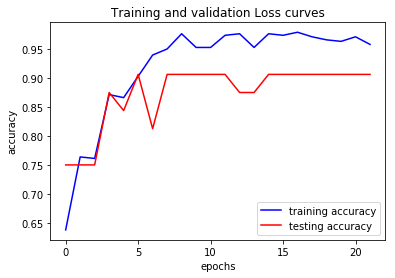

In [692]:
plt.plot(history_record[0].history['acc'],color='b',label='training accuracy')
plt.plot(history_record[0].history['val_acc'],color='r',label='testing accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and validation Loss curves')
plt.legend()
plt.savefig('gender-accuracy-simple.jpg')
plt.show()

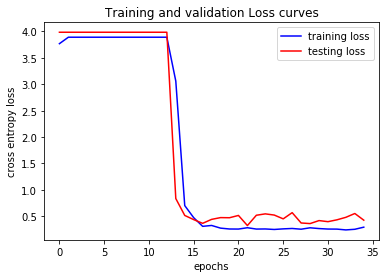

In [697]:
plt.plot(history_record[1].history['loss'],color='b',label='training loss')
plt.plot(history_record[1].history['val_loss'],color='r',label='testing loss')
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.title('Training and validation Loss curves')
plt.legend()
plt.savefig('gender-loss-simple.jpg')
plt.show()